## LSTM (Long Short-Term Memory) is a type of recurrent neural network (RNN) designed to address the problem of capturing long-term dependencies in sequential data.
### LSTM Gates
1. Forget Gate: Controls what information from the previous cell state should be discarded or kept based on the current input.

2. Input Gate: Determines which new information from the current input should be stored in the cell state.

3. Cell State: Represents the memory of the LSTM, preserving information over long sequences by selectively adding or removing information.

4. Output Gate: Filters the information from the current cell state to produce the output based on the current input and the LSTM's internal state.


#### LSTM (Long Short-Term Memory) is a type of RNN (Recurrent Neural Network) designed to address the issue of capturing long-term dependencies in sequential data.

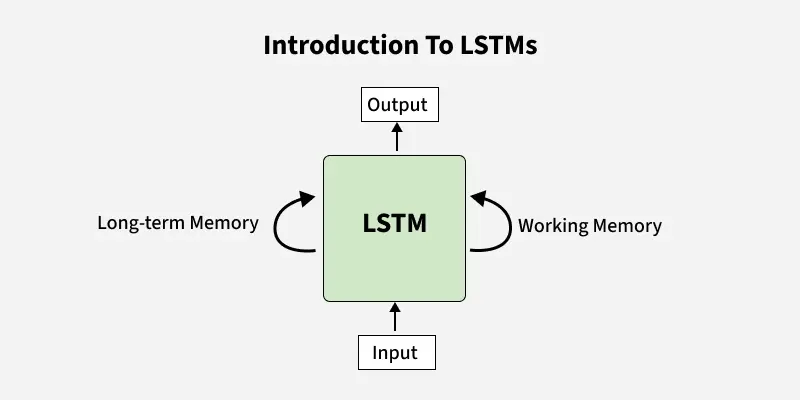
- LSTMs have a memory cell that can retain information over long periods.
- They incorporate gating mechanisms (input, forget, and output gates) to control the flow of information into and out of the memory cell.
- Input gate: Determines which new information to incorporate into the memory cell.
- Forget gate: Decides which information to discard from the memory cell.
- Output gate: Regulates the information output from the memory cell to the next time step.
- LSTMs are trained using backpropagation through time (BPTT), allowing them to learn to capture long-range dependencies in the data.
- LSTMs are widely used in tasks such as language modeling, speech recognition, and time series prediction due to their ability to effectively capture long-range dependencies.
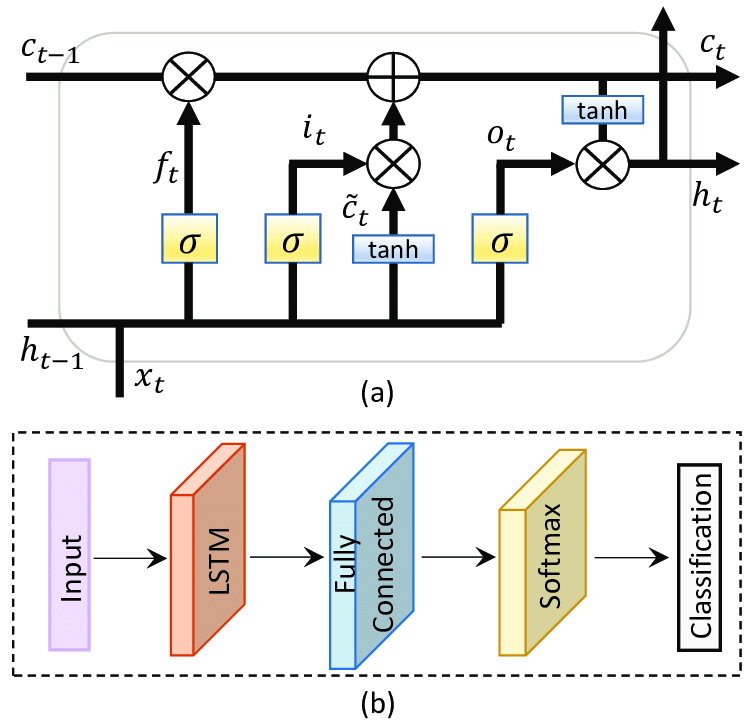

### Text Generation using Recurrent Long Short Term Memory Network

- LSTMs are a type of neural network that are well-suited for tasks involving sequential data such as text generation. 
- They are particularly useful because they can remember long-term dependencies in the data which is crucial when dealing with text that often has context that spans over multiple words or sentences. 

## Step1: Importing required Lib 

In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
import random
import sys

In [2]:
df = pd.read_csv('Text.csv')
text = " ".join(df['text'].dropna().astype(str)).lower()

print(f'Total characters in text: {len(text)}')

Total characters in text: 35695884


- pd.read_csv(): Reads the CSV file into a DataFrame.
- df['text'].dropna(): Drops rows with missing text entries.
- " ".join(): Concatenates all text rows into a single string for training.
- .lower(): Converts text to lowercase for consistency.

In [3]:
df

,title,text,subject,date
0,Greens say no support for Macron's EZ budget i...,BERLIN (Reuters) - None of the German parties ...,worldnews,"October 25, 2017"
1,Trump faces uphill battle to overcome court's ...,(Reuters) - U.S. President Donald Trump faces ...,politicsNews,"February 6, 2017"
2,Ukraine president denies hampering anti-corrup...,VILNIUS/KIEV (Reuters) - Ukrainian President P...,worldnews,"December 8, 2017"
3,U.S. defense chief: White House shakeup will n...,BRUSSELS (Reuters) - U.S. Defense Secretary Ji...,politicsNews,"February 14, 2017"
4,Irish government set to fall weeks before Brex...,DUBLIN (Reuters) - Ireland s minority governme...,worldnews,"November 24, 2017"
...,...,...,...,...
14986,British negotiators still working on Brexit de...,LONDON (Reuters) - British negotiators are sti...,worldnews,"November 29, 2017"
14987,Democratic voter-intimidation cases falter in ...,WASHINGTON (Reuters) - Democrats fell short in...,politicsNews,"November 7, 2016"
14988,Cyprus president to seek second five-year term...,NICOSIA (Reuters) - Cypriot President Nicos An...,worldnews,"October 14, 2017"
14989,Trump says strong Europe is important for U.S,WASHINGTON (Reuters) - President Donald Trump ...,politicsNews,"April 20, 2017"


## Creating Vocabulary and Character Mappings
- sorted(set(text)): Extracts unique characters and sorts them to form the vocabulary.
- char2idx: Maps each character to a unique integer index.
- idx2char: Maps integers back to characters and is used during text generation.
- text_as_int: Converts the entire text into a sequence of integer indices.

In [5]:
vocab = sorted(set(text))
print(f'Vocabulary size: {len(vocab)}')

char2idx = {c: i for i, c in enumerate(vocab)}
idx2char = np.array(vocab)

text_as_int = np.array([char2idx[c] for c in text])

Vocabulary size: 104


## Pre-processing the Data

We will ceate dataset from integer encoded text and split sequences into input and target. Then we will shuffle and divide the dataset into batches.

- seq_length: Defines the length of input sequences for the model.
- tf.data.Dataset.from_tensor_slices(): Converts the integer sequence into a TensorFlow dataset.
- batch(seq_length + 1): Creates sequences of length 101 where first 100 are input and the last is the target.
- split_input_target(): Splits each sequence into input and target (next character).
- shuffle() and batch(): Randomizes data order and creates batches for training.

In [7]:
seq_length = 100 

char_dataset = tf.data.Dataset.from_tensor_slices(text_as_int)

sequences = char_dataset.batch(seq_length + 1, drop_remainder=True)

def split_input_target(chunk):
    return chunk[:-1], chunk[1:]

dataset = sequences.map(split_input_target)

BATCH_SIZE = 64
BUFFER_SIZE = 10000

dataset = dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE, drop_remainder=True)

## Building the LSTM Model
LSTM model with the following layers and compile the model. We will be using RMSprop optimizer in this model.

- Embedding layer: Converts integer indices into dense vectors of length embedding_dim.
- LSTM layer: Processes sequences capturing temporal dependencies with rnn_units memory cells. return_sequences=True outputs sequence at each timestep.
- Dense layer: Produces output logits for all characters in the vocabulary to predict the next character.

### RMSProp (Root Mean Square Propagation) is an adaptive learning rate optimization algorithm designed to improve the performance and speed of training deep learning models.

It is a variant of the gradient descent algorithm which adapts the learning rate for each parameter individually by considering the magnitude of recent gradients for those parameters.
This adaptive nature helps in dealing with the challenges of non-stationary objectives and sparse gradients commonly encountered in deep learning tasks.
Need of RMSProp Optimizer
RMSProp was developed to address the limitations of previous optimization methods such as SGD (Stochastic Gradient Descent) and AdaGrad as SGD uses a constant learning rate which can be inefficient and AdaGrad reduces the learning rate too aggressively.

In [8]:
vocab_size = len(vocab)
embedding_dim = 64
rnn_units = 128

model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_shape=(None,)),
    tf.keras.layers.LSTM(rnn_units, return_sequences=True, recurrent_initializer='glorot_uniform'),
    tf.keras.layers.Dense(vocab_size)
])


def loss(labels, logits):
    return tf.keras.losses.sparse_categorical_crossentropy(labels, logits, from_logits=True)

model.compile(optimizer='adam', loss=loss)

model.summary()

C:\Users\Suyashi144893\AppData\Local\anaconda3\Lib\site-packages\keras\src\layers\core\embedding.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding (Embedding)                │ (None, None, 64)            │           6,656 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm (LSTM)                          │ (None, None, 128)           │          98,816 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, None, 104)           │          13,416 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 118,888 (464.41 KB)

 Trainable params: 118,888 (464.41 KB)

 Non-trainable params: 0 (0.00 B)

### Training the LSTM model
 
- Train our model on 20 Epochs to use it for predictions.

- model.fit(): Trains the model on the dataset for 20 epochs.
- history: Stores training metrics for later analysis.

In [ ]:
EPOCHS = 20
history = model.fit(dataset, epochs=EPOCHS)

Epoch 1/20
5522/5522 ━━━━━━━━━━━━━━━━━━━━ 410s 74ms/step - loss: 2.1128
Epoch 2/20
5522/5522 ━━━━━━━━━━━━━━━━━━━━ 439s 79ms/step - loss: 1.4992
Epoch 3/20
5522/5522 ━━━━━━━━━━━━━━━━━━━━ 447s 81ms/step - loss: 1.4056
Epoch 4/20
5522/5522 ━━━━━━━━━━━━━━━━━━━━ 440s 79ms/step - loss: 1.3661
Epoch 5/20
5522/5522 ━━━━━━━━━━━━━━━━━━━━ 455s 82ms/step - loss: 1.3433
Epoch 6/20
5522/5522 ━━━━━━━━━━━━━━━━━━━━ 449s 81ms/step - loss: 1.3284
Epoch 7/20
5522/5522 ━━━━━━━━━━━━━━━━━━━━ 404s 73ms/step - loss: 1.3177
Epoch 8/20
5522/5522 ━━━━━━━━━━━━━━━━━━━━ 402s 73ms/step - loss: 1.3094
Epoch 9/20
5522/5522 ━━━━━━━━━━━━━━━━━━━━ 434s 78ms/step - loss: 1.3028
Epoch 10/20
5522/5522 ━━━━━━━━━━━━━━━━━━━━ 426s 77ms/step - loss: 1.2973
Epoch 11/20
5522/5522 ━━━━━━━━━━━━━━━━━━━━ 403s 73ms/step - loss: 1.2925
Epoch 12/20
5407/5522 ━━━━━━━━━━━━━━━━━━━━ 9s 79ms/step - loss: 1.2887

### Generating new random text


- start_string: Initial seed text to start generation.
- temperature: Controls randomness; lower values make output more predictable, higher values more creative.
- model.reset_states(): Clears LSTM states before generation.
- tf.random.categorical(): Samples the next character probabilistically from the model’s predictions.
- Returns: The seed text plus generated characters.

In [ ]:
def generate_text(model, start_string, num_generate=100, temperature=1.0):
    input_eval = [char2idx.get(s, 0) for s in start_string.lower()]
    input_eval = tf.expand_dims(input_eval, 0)

    text_generated = []

    model.layers[1].reset_states()  # Reset LSTM layer states

    for _ in range(num_generate):
        predictions = model(input_eval)
        predictions = tf.squeeze(predictions, 0) / temperature
        predicted_id = tf.random.categorical(predictions, num_samples=1)[-1, 0].numpy()

        input_eval = tf.expand_dims([predicted_id], 0)
        text_generated.append(idx2char[predicted_id])

    return start_string + ''.join(text_generated)
    
print(generate_text(model, start_string="The ", num_generate=200, temperature=0.8))